In [1]:
import grafiti as gf
import cellcharter as cc
from utag import utag
import scvi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata
import squidpy as sq
import scanpy as sc
import seaborn as sns
from scipy.stats import norm
import random
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score, mutual_info_score
import warnings
warnings.filterwarnings("ignore")

/home/pourmalm/ondconda/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/pourmalm/ondconda/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
 captum (see https://github.com/pytorch/captum).


# Scenario 3 synthetic

In [2]:
def generate_synthetic_dataset(
    num_cells=2000,
    cluster_probability=0.5,
    cluster_size=100,
    cluster_radius=0.01,
    marker_means_A=(0.3, 0.8), 
    marker_means_B=(0.8, 0.3),
    marker_SDs_A=(0.1, 0.1), 
    marker_SDs_B=(0.1, 0.1),
    dispersed_distance=0.05,
    num_markers=4,
    seed=25):

    random.seed(seed)
    np.random.seed(seed)
    
    # Generate unique x and y coordinates for all cells in the range [0, 1)
    x = np.random.rand(num_cells)
    y = np.random.rand(num_cells)

    # Generate topology (clustered or dispersed) based on x and y coordinates
    topology = np.where(np.random.rand(num_cells) < cluster_probability, 'clustered', 'dispersed')

    # Adjust x and y coordinates for clustered cells
    clustered_indices = np.where(topology == 'clustered')[0]
    for i in range(0, len(clustered_indices), cluster_size):
        cluster_x = np.random.normal(loc=x[clustered_indices[i]], scale=cluster_radius,
                                      size=min(cluster_size, len(clustered_indices) - i))
        cluster_y = np.random.normal(loc=y[clustered_indices[i]], scale=cluster_radius,
                                      size=min(cluster_size, len(clustered_indices) - i))

        # Clip the generated coordinates to ensure they are within [0, 1)
        cluster_x = np.clip(cluster_x, 0, 1)
        cluster_y = np.clip(cluster_y, 0, 1)

        # Filter out indices where the generated coordinates are too close to existing clustered cells
        valid_indices = np.where(
            (np.abs(cluster_x - x[clustered_indices[i:i + cluster_size]]) > cluster_radius) |
            (np.abs(cluster_y - y[clustered_indices[i:i + cluster_size]]) > cluster_radius))[0]

        # Update only the valid indices with the new coordinates
        x[clustered_indices[i:i + cluster_size][valid_indices]] = cluster_x[valid_indices]
        y[clustered_indices[i:i + cluster_size][valid_indices]] = cluster_y[valid_indices]

    # Adjust x and y coordinates for dispersed cells based on clustered cells
    dispersed_indices = np.where(topology == 'dispersed')[0]
    for i in dispersed_indices:
        # Check if the dispersed cell is within a specified distance of any clustered cell
        while any(
                np.sqrt((x[i] - x[clustered_indices]) ** 2 + (y[i] - y[clustered_indices]) ** 2) < dispersed_distance):
            # If the dispersed cell is too close to a cluster, generate new coordinates
            x[i] = np.random.uniform(low=0, high=1)
            y[i] = np.random.uniform(low=0, high=1)

    # Assign cell types based on coordinates
    celltype_A_mask = (x < 0.5) & (y >= 0) & (y <= 1)
    celltype_B_mask = (x >= 0.5) & (y >= 0) & (y <= 1)

    # Generate marker values using bimodal distribution for each marker
    markers = []
    for i in range(num_markers):
        # Determine the upregulated and downregulated cell types
        upregulated_celltype = 'celltype_B' if i % 2 == 0 else 'celltype_A'
        downregulated_celltype = 'celltype_A' if i % 2 == 0 else 'celltype_B'
        
        # Generate values for the upregulated cell type
        upregulated_values = np.clip(np.random.normal(loc=marker_means_A[i % 2], scale=marker_SDs_A[i % 2], size=num_cells), 0, 1)
        
        # Generate values for the downregulated cell type
        downregulated_values = np.clip(np.random.normal(loc=marker_means_B[i % 2], scale=marker_SDs_B[i % 2], size=num_cells), 0, 1)
        
        # Combine values based on the cell type
        marker_values = np.where(celltype_A_mask, upregulated_values, downregulated_values)
        markers.append(marker_values)

    # Create a DataFrame to store the synthetic dataset
    data_dict = {'x': x, 
                 'y': y, 
                 'celltype': np.where(celltype_A_mask, 'celltype_A', 'celltype_B'), 
                 'topology': topology}
    for i in range(num_markers):
        data_dict[f'marker_{i+1}'] = markers[i]

    synthetic_data = pd.DataFrame(data_dict)

    return synthetic_data

0


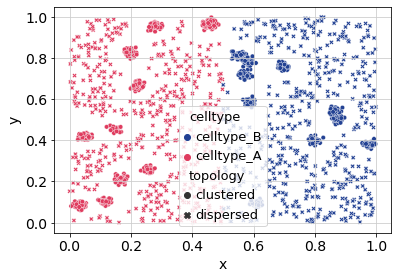

Generating PyTorch Geometric Dataset...
Setting up Model...
Ready to train!
Epoch 0 ** iteration 0 ** Loss: 27734.83203125
Epoch 50 ** iteration 50 ** Loss: 20222.27107421875
Epoch 100 ** iteration 100 ** Loss: 10026.420693359374
Epoch 150 ** iteration 150 ** Loss: 4232.96134765625
Complete.
Applying UTAG Algorithm...


  0%|          | 0/1 [00:00<?, ?it/s]

1


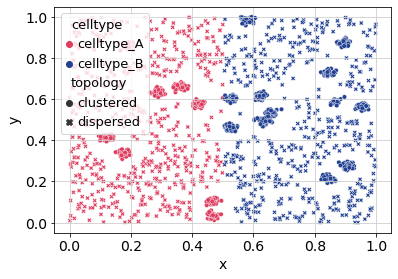

Generating PyTorch Geometric Dataset...
Setting up Model...
Ready to train!
Epoch 0 ** iteration 0 ** Loss: 3051.617919921875
Epoch 50 ** iteration 50 ** Loss: 1720.913328857422
Epoch 100 ** iteration 100 ** Loss: 300.803710231781
Epoch 150 ** iteration 150 ** Loss: 3.215750231742859
Complete.
Applying UTAG Algorithm...


  0%|          | 0/1 [00:00<?, ?it/s]

In [96]:
columns = ['run', 'grafiti_top', 'cellcharter_top', 'utag_top', 'grafiti_ct', 'cellcharter_ct', 'utag_ct']
synthetic_iter = pd.DataFrame(columns=columns)
for i in range(2):
    print(i)
    synthetic_dataset = generate_synthetic_dataset(num_cells=2000,
                                                   cluster_probability=0.5,
                                                   cluster_size=50,
                                                   cluster_radius=0.01,
                                                   marker_means_A=(0.3, 0.8),
                                                   marker_means_B=(0.8, 0.3),
                                                   marker_SDs_A=(0.1, 0.1),
                                                   marker_SDs_B=(0.1, 0.1),
                                                   dispersed_distance=0.05,
                                                   num_markers=4,
                                                   seed=i)
    sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['celltype'], s=20, 
                    palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'}, style=synthetic_dataset["topology"])
    plt.show()
    synthetic_dataset["fov"] = "FOV1"
    synthetic_dataset["fov"] = synthetic_dataset["fov"].astype("category")
    synthetic_dataset['true_label'] = synthetic_dataset['celltype'] + '_' + synthetic_dataset['topology']
    features = ["marker_1", "marker_2", "marker_3", "marker_4"]
    obs_features = ["x", "y", "celltype", "topology", "true_label", "fov"]
    adata = anndata.AnnData(X = synthetic_dataset[features].to_numpy(), obs = synthetic_dataset[obs_features])
    adata.var_names = synthetic_dataset[features].columns
    adata.obsm['spatial'] = adata.obs[["x","y"]].to_numpy()
    sq.gr.spatial_neighbors(adata,radius=10,coord_type='generic',delaunay=True,library_key="fov")
    # grafiti
    gae = gf.ml.GAE(adata, layers=[10], lr=0.1, distance_threshold=0.08)
    gae.train(200, update_interval=50)
    gae.load_embedding(adata,encoding_key="X_grafiti")
    # cell charter
#     scvi.settings.seed = 12345
#     scvi.model.SCVI.setup_anndata(adata,batch_key='fov')
#     model = scvi.model.SCVI(adata)
#     model.train(early_stopping=True, enable_progress_bar=True)
#     adata.obsm['X_scVI'] = model.get_latent_representation(adata).astype(np.float32)
#     cc.gr.aggregate_neighbors(adata, n_layers=3, use_rep='X_scVI', out_key='X_cellcharter', sample_key='fov')
    # utag
    utag_results = utag(adata,slide_key="fov",max_dist=0.08,normalization_mode=None,apply_clustering=False)
    dbs_gf_top = davies_bouldin_score(adata.obsm['X_grafiti'], adata.obs["topology"])
#     dbs_cc_top = davies_bouldin_score(adata.obsm['X_cellcharter'], adata.obs["topology"])
    dbs_ut_top = davies_bouldin_score(utag_results.X, utag_results.obs["topology"])
    
    dbs_gf_ct = davies_bouldin_score(adata.obsm['X_grafiti'], adata.obs["celltype"])
#     dbs_cc_ct = davies_bouldin_score(adata.obsm['X_cellcharter'], adata.obs["celltype"])
    dbs_ut_ct = davies_bouldin_score(utag_results.X, utag_results.obs["celltype"])
    
    
    synthetic_iter = synthetic_iter.append({'run': i,
                    'grafiti_top': dbs_gf_top,
                    'cellcharter_top': dbs_cc_top,
                    'utag_top': dbs_ut_top,
                    'grafiti_ct': dbs_gf_ct,
                    'cellcharter_ct': dbs_cc_ct,
                    'utag_ct': dbs_ut_ct}, ignore_index=True)

In [49]:
synthetic_iter

,run,grafiti_top,cellcharter_top,utag_top,grafiti_ct,cellcharter_ct,utag_ct
0,0.0,0.869064,59.305115,84.476749,2.212427,0.159022,0.372814
1,1.0,0.737244,7.514705,8.026833,2.315531,0.158985,0.375887
2,2.0,0.762482,8.479968,8.733757,3.910846,0.169083,0.374465
3,3.0,1.159729,5.307964,5.337164,1.525647,0.170433,0.368659
4,4.0,0.765199,21.899280,22.322989,2.455920,0.174150,0.373153
5,5.0,0.750120,11.456524,11.725537,3.682026,0.204593,0.376679
6,6.0,0.731525,25.736063,20.528775,2.518918,0.166243,0.373558
7,7.0,0.745646,43.651221,112.847609,2.898162,0.173079,0.370519
8,8.0,0.756131,7.605412,7.897389,4.109015,0.186310,0.375683
9,9.0,0.700095,8.793141,9.004020,2.551435,0.187847,0.371265


In [101]:
synthetic_iter

,run,grafiti_top,cellcharter_top,utag_top,grafiti_ct,cellcharter_ct,utag_ct
0,0.0,1.204440,8.793141,1.154019,1.377825,0.187847,1.205495
1,1.0,0.814532,8.793141,1.164841,2.573838,0.187847,1.153575


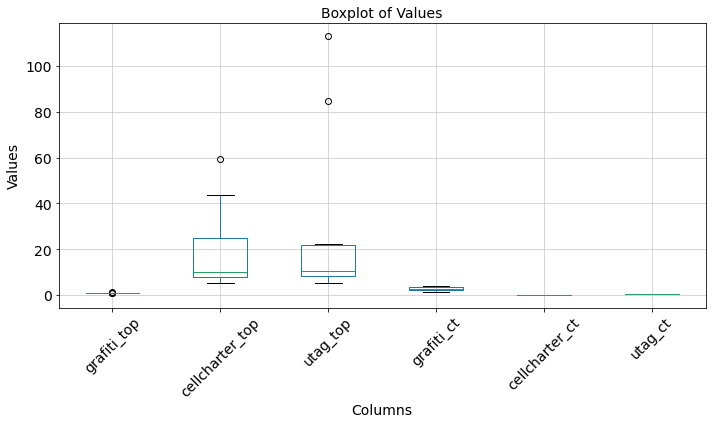

In [50]:
df_plot = synthetic_iter.drop(columns=['run'])

# Plot
plt.figure(figsize=(10, 6))
df_plot.boxplot()
plt.title('Boxplot of Values')
plt.ylabel('Values')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

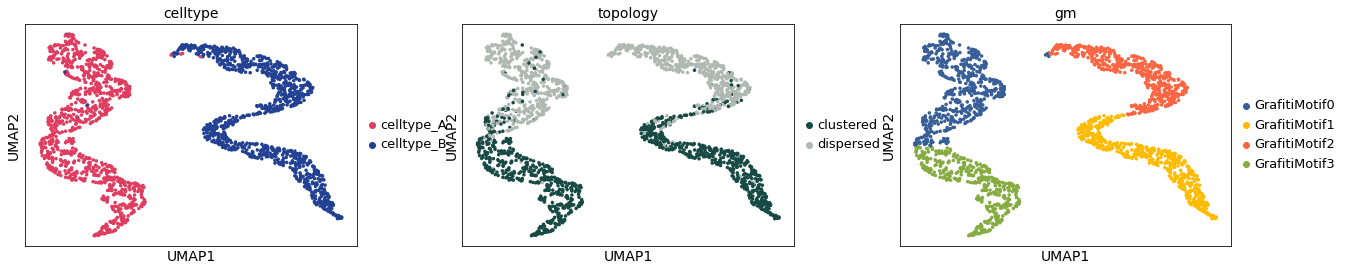

<Axes: xlabel='x', ylabel='y'>

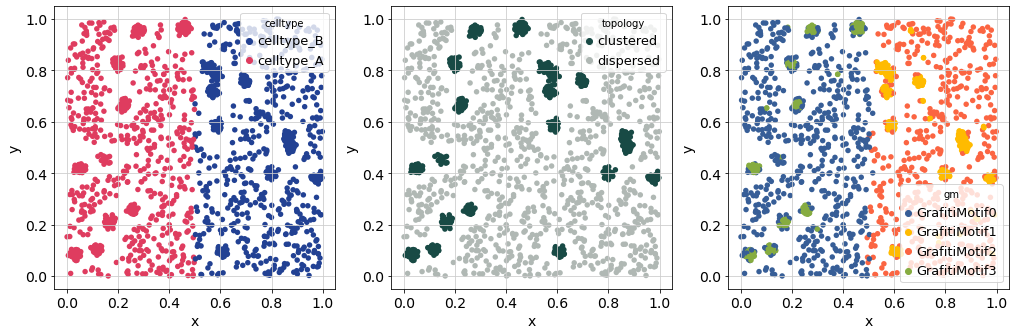

In [37]:
sc.pp.neighbors(adata,use_rep="X_grafiti")
sc.tl.umap(adata)
gf.tl.find_motifs(adata, resolution=0.08, method="leiden", cluster_key="gm")
colors={'celltype_A':'#df3c5f','celltype_B':'#224193','clustered':'#184A45FF','dispersed':'#B0B8B4FF',
        'GrafitiMotif0':'#375e97', 'GrafitiMotif1':'#ffbb00', 'GrafitiMotif2':'#fb6542', 'GrafitiMotif3':'#86ac41'}
sc.pl.umap(adata,color=["celltype","topology","gm"], s=50, add_outline=False, wspace=0.2, 
           legend_loc='right margin',palette=colors)
plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['celltype'], s=30, linewidth=0.001, palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})
plt.subplot(1, 3, 2)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['topology'], s=30, linewidth=0.001, palette={'clustered':'#184A45FF', 'dispersed':'#B0B8B4FF'})
plt.subplot(1, 3, 3)
sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['gm'], s=30, linewidth=0.001, palette={'GrafitiMotif0':'#375e97', 'GrafitiMotif1':'#ffbb00', 'GrafitiMotif2':'#fb6542', 'GrafitiMotif3':'#86ac41'})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=2` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


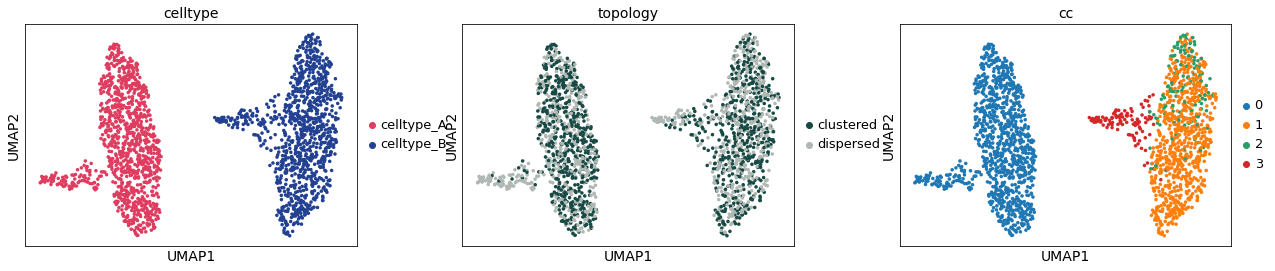

<Axes: xlabel='x', ylabel='y'>

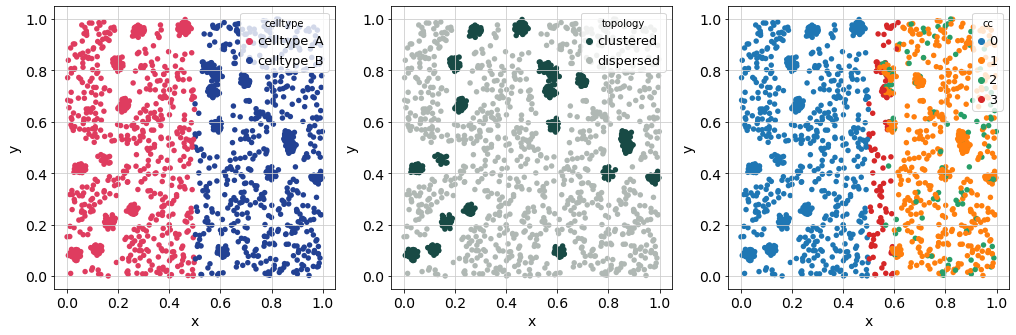

In [38]:
sc.pp.neighbors(adata,use_rep="X_cellcharter")
sc.tl.umap(adata)
gmm = cc.tl.Cluster(
    n_clusters=4, 
    random_state=12345,
)
gmm.fit(adata, use_rep='X_cellcharter')
adata.obs['cc'] = gmm.predict(adata, use_rep='X_cellcharter')
sc.pl.umap(adata,color=["celltype","topology","cc"], s=50, add_outline=False, wspace=0.2, 
           legend_loc='right margin')
plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['celltype'], s=30, linewidth=0.001, palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})
plt.subplot(1, 3, 2)
sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['topology'], s=30, linewidth=0.001, palette={'clustered':'#184A45FF', 'dispersed':'#B0B8B4FF'})
plt.subplot(1, 3, 3)
sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['cc'], s=30, linewidth=0.001)

Applying UTAG Algorithm...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Applying Leiden Clustering at Resolution: 0.05...


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


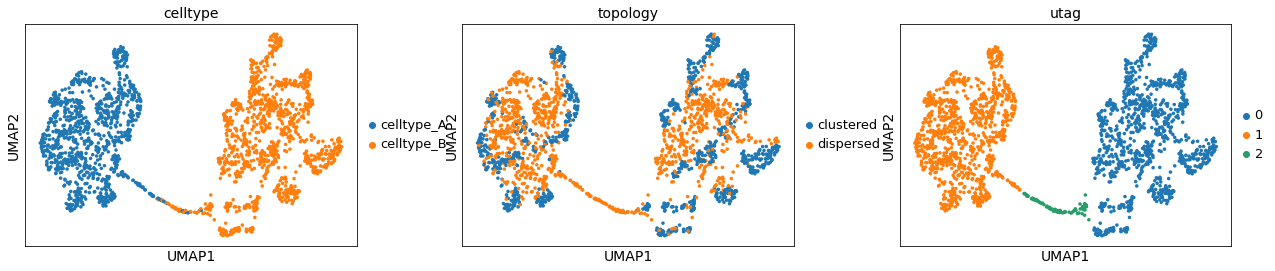

<Axes: xlabel='x', ylabel='y'>

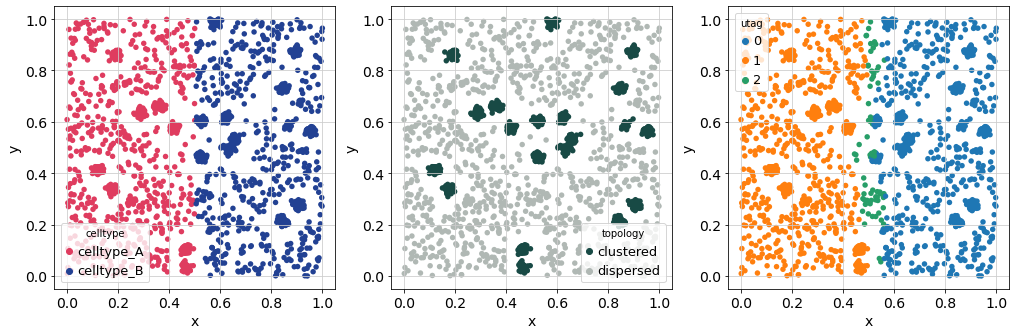

In [105]:
utag_results = utag(
    adata,
    slide_key="fov",
    max_dist=0.08,
    normalization_mode='l1_norm',
    apply_clustering=True,
    clustering_method = 'leiden', 
    resolutions = [0.05]
)
adata.obsm['X_utag'] = utag_results.X
adata.obs['utag'] = utag_results.obs['UTAG Label_leiden_0.05']
sc.pp.neighbors(adata,use_rep='X_utag')
sc.tl.umap(adata)
sc.pl.umap(adata,color=["celltype","topology","utag"], s=50, add_outline=False, wspace=0.2, 
           legend_loc='right margin')
plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['celltype'], s=30, linewidth=0.001, palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})
plt.subplot(1, 3, 2)
sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['topology'], s=30, linewidth=0.001, palette={'clustered':'#184A45FF', 'dispersed':'#B0B8B4FF'})
plt.subplot(1, 3, 3)
sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['utag'], s=30, linewidth=0.001)

## Final comparison

In [43]:
# plt.figure(figsize=(36, 6))
# plt.subplot(1, 5, 1)
# sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['celltype'], s=30, linewidth=0.001, palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})
# plt.subplot(1, 5, 2)
# sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['topology'], s=30, linewidth=0.001, palette={'clustered':'#184A45FF', 'dispersed':'#B0B8B4FF'})
# plt.subplot(1, 5, 3)
# sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['grafiti_motif'], s=30, linewidth=0.001)
# plt.subplot(1, 5, 4)
# sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['cc'], s=30, linewidth=0.001)
# plt.subplot(1, 5, 5)
# sns.scatterplot(x=utag_results.obs['x'], y=utag_results.obs['y'], hue=utag_results.obs['UTAG Label_leiden_0.33'], s=30, linewidth=0.001)

In [97]:
adata

AnnData object with n_obs × n_vars = 2000 × 4
    obs: 'x', 'y', 'celltype', 'topology', 'true_label', 'fov'
    uns: 'spatial_neighbors'
    obsm: 'spatial', 'X_grafiti'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [98]:
adata.X

array([[0.18, 0.78, 0.17, 0.87],
       [0.82, 0.4 , 0.75, 0.45],
       [0.21, 0.83, 0.28, 0.85],
       [0.19, 0.77, 0.35, 0.82],
       [0.41, 0.72, 0.2 , 0.85],
       [0.28, 0.69, 0.34, 0.63],
       [0.45, 0.82, 0.3 , 0.75],
       ...,
       [0.76, 0.27, 0.93, 0.36],
       [0.71, 0.41, 0.7 , 0.2 ],
       [0.72, 0.2 , 0.83, 0.29],
       [0.36, 0.81, 0.32, 0.78],
       [0.63, 0.28, 0.86, 0.46],
       [0.66, 0.59, 0.35, 0.98],
       [0.8 , 0.33, 0.9 , 0.26]])

In [99]:
utag_results

AnnData object with n_obs × n_vars = 2000 × 4
    obs: 'x', 'y', 'celltype', 'topology', 'true_label', 'fov'
    obsm: 'spatial', 'X_grafiti'

In [100]:
utag_results.X

array([[16.11, 42.79, 14.73, 43.2 ],
       [22.25,  8.26, 21.75,  7.94],
       [ 6.15, 15.  ,  5.34, 15.24],
       [16.52, 43.73, 15.19, 44.09],
       [11.04, 27.27, 10.2 , 27.33],
       [15.83, 41.97, 14.57, 42.39],
       [16.43, 43.54, 15.19, 44.07],
       ...,
       [35.76, 13.73, 37.03, 14.15],
       [18.69,  7.54, 20.2 ,  8.21],
       [39.94, 15.33, 41.3 , 15.55],
       [10.46, 24.61,  9.01, 25.84],
       [54.02, 20.6 , 56.47, 21.25],
       [ 8.04, 19.94,  6.82, 20.43],
       [19.65,  7.42, 20.81,  7.69]])

In [70]:
utag_results_wclust.X

array([[0.55, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       ...,
       [0.55, 0.55, 0.55, 0.55],
       [0.54, 0.55, 0.55, 0.55],
       [0.54, 0.55, 0.55, 0.55],
       [0.54, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       [0.54, 0.55, 0.55, 0.55],
       [0.54, 0.55, 0.55, 0.55]])

In [80]:
utag_results_noclust = utag(
    adata,
    slide_key='fov',
    max_dist=15,
    normalization_mode='l1_norm',
    apply_clustering=False)

Applying UTAG Algorithm...


  0%|          | 0/1 [00:00<?, ?it/s]

In [81]:
utag_results_noclust.X

array([[0.55, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       ...,
       [0.55, 0.55, 0.55, 0.55],
       [0.54, 0.55, 0.55, 0.55],
       [0.54, 0.55, 0.55, 0.55],
       [0.54, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       [0.54, 0.55, 0.55, 0.55],
       [0.54, 0.55, 0.55, 0.55]])

In [87]:
adata

AnnData object with n_obs × n_vars = 2000 × 4
    obs: 'x', 'y', 'celltype', 'topology', 'true_label', 'fov'
    uns: 'spatial_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [88]:
adata.X

array([[0.8 , 0.39, 0.67, 0.33],
       [0.7 , 0.24, 0.74, 0.44],
       [0.68, 0.  , 0.9 , 0.32],
       [0.77, 0.23, 0.82, 0.47],
       [0.71, 0.24, 0.88, 0.33],
       [0.98, 0.33, 0.87, 0.25],
       [0.7 , 0.44, 0.67, 0.14],
       ...,
       [1.  , 0.2 , 0.83, 0.28],
       [0.36, 0.77, 0.31, 0.89],
       [0.23, 0.74, 0.2 , 0.65],
       [0.25, 0.91, 0.35, 0.73],
       [0.87, 0.24, 0.58, 0.26],
       [0.23, 0.8 , 0.19, 0.64],
       [0.34, 0.83, 0.2 , 0.74]])

In [91]:
utag_results_noclust = utag(
    adata,
    slide_key=None,
    max_dist=15,
    normalization_mode='l1_norm',
    apply_clustering=False)

Applying UTAG Algorithm...


In [92]:
utag_results_noclust.X

array([[0.55, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       ...,
       [0.55, 0.55, 0.55, 0.55],
       [0.54, 0.55, 0.55, 0.55],
       [0.54, 0.55, 0.55, 0.55],
       [0.54, 0.55, 0.55, 0.55],
       [0.55, 0.55, 0.55, 0.55],
       [0.54, 0.55, 0.55, 0.55],
       [0.54, 0.55, 0.55, 0.55]])